# Information for data
- The SMS Spam collection is a set of SMS tagged messages that have been collected for the SMS Spam Reseach. It contained one set of SMS messages in English of 5574 messages, tagged acording beign ham(legitimate) or spam
- The file contain one message per line. Each line is composed by 2 columns: v1 contains the label(ham or spam) and v2 contains the raw text


# Task: Build a prediction model that will accurately classify whichs texts are spam.

In [92]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM,Activation,Dense,Dropout,Input,Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import sequence
from keras.utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping 
#%matplotlib inline

# 1 Prepair data from LSTM

In [93]:
data=pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [94]:
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True);
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number ham and spam messages')

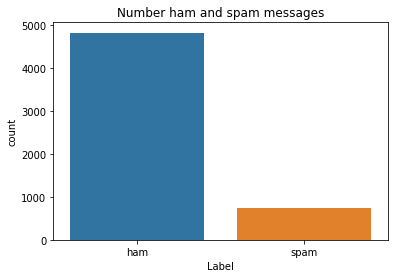

In [95]:
sns.countplot(data.v1)
plt.xlabel('Label')
plt.title('Number ham and spam messages')

In [96]:
x=data.v2
y=data.v1
label_encoder=LabelEncoder()
y=label_encoder.fit_transform(y)
print(y.shape)
y=y.reshape(-1,1)
print(y.shape)

(5572,)
(5572, 1)


# Tokenization 
- **Tokenization** is one first step in NLP, and it's the task of splitting a sequence of text into units with semantic meaning. These units are called tokens, and the difficultly in tokenization lies on hwo to get the idel split so that all the tokens in the text have the correct meaning, there are no left out tokens
  - **Example** :
    - **Raw text**: I ate a burger, and it was good.
    - **Tokenized text**: [’I’, ’ate’, ’a’, ’burger’, ‘,’, ‘and’, ’it’, ’was’, ’good’, ‘.’]

- **A few common way of tokenizing:**
  - **Word level tokenization**:
     - It consists only of splitting a sentence by the whitespace and puntuation marks.Splitting on whitespace can also split an element which should be regarded as a single token, for example New York. This is problematic and mostly the case with names, borrowed foregin phrases, and compounds thath are sometimes written as mutiple words 
     - Another drawback of word level tokenization is the huge vocabulary size is creates. Each token is saved into to a token vocabulary, and if the vocabulary is build with all the unique words found in all the input text, it creates a huge vocabulary, which procedure memory and performance problems later on. To solve the problem of the bif vocabulary size, we can think of creating tokens with **characters instead of works**, which is called level tokenization

  - **Character level tokenization:**
    - The vocabulary size is dramatically reduced to the number of characters in the language, 26 for English plus the special characters. Misspellings or rare words are handled better because they are broken down into characters and these characters are already known in the vocabulary.
    - Reduncing the vocabulary size has a tradeoff with the sequence length. Now each word being splitted into its characters, the tokenized sequence is much longer than the initial text. The word 'smarter' is transformed into 7 different tokens. Additinally, the main goal of tokenization isn't achieved, because characters, at least in English, have no semantic meaning. Only when joining characters together to they acquire a meaning. **As an in-betweener between word and character tokenization, subword tokenization procedure subword units,smaller than words but bigger than just character**

  - **Subword level tokenization:**
     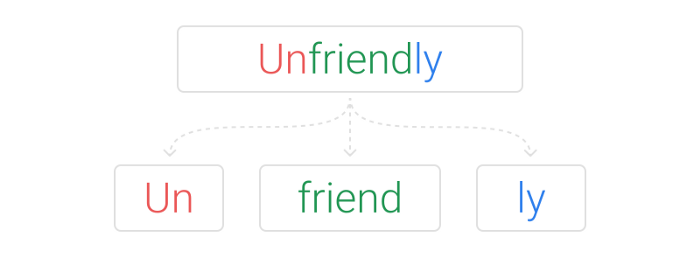
     - Subword level tokenization doesn't transform most common words, and decompose rare words in meaning ful subword units. If 'unfriendly' was labeled as a rare word, it would e decompose into 'un-friend-ly' which are all meaningful unit, ‘un’ meaning opposite, ‘friend’ is a noun, and ‘ly’ turns it into an adverb. The challenge here is how to make that segmentation, how do we get ‘un-friend-ly’ and not ‘unfr-ien-dly’.
  - **BPE**
  - **Unigram LM**
  - **Word piece**


In [97]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.15)

In [98]:
print(x_train)

2825                                            Ok lor...
3783              Dear got train and seat mine lower seat
810                            S:)s.nervous  &lt;#&gt; :)
1434      I asked sen to come chennai and search for job.
4761                      Me too! Have a lovely night xxx
                              ...                        
154     You are everywhere dirt, on the floor, the win...
1210            Guessin you ain't gonna be here before 9?
263     Hey I am really horny want to chat or see me n...
355     Thank You for calling.Forgot to say Happy Onam...
254                I'm back, lemme know when you're ready
Name: v2, Length: 4736, dtype: object


# Precess the data
- Tokenize the data and convert the text to sequences(convert text into the list of words)
- Add padding to ensure that all the sequences have the same shape
- There are many way of taking the max_len and here an arbitrary length of 150 is chosen 
- **pad_senquences**: is used to ensure that all sequences in a list have the same length. By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence.

In [102]:
data=""
for string in x_train:
  data+=str(string)+" "

In [103]:
import string
data=data.translate(str.maketrans('','',string.punctuation))
word_dic=dict.fromkeys(set(data.split(' ')),0)
for word in data.split(' '):
  word_dic[word]+=1
sorted(word_dic.items(),key= lambda x:x[1],reverse=True)
freqs=word_dic.values()
c=np.array(list(freqs))
print(c)
count=50
print("Number words have number appear > {} :".format(count),len(np.where(c>count)[0]))



[1564    2    1 ...    1    1    1]
Number words have number appear > 50 : 213


In [104]:
max_words=200# we choose 200 words which have number appear in dict > 50
max_len=150
tokenize=Tokenizer(num_words=max_words)
tokenize.fit_on_texts(x_train) #create internal dictionary
print(x_train.shape)
sequences=tokenize.texts_to_sequences(x_train)
print(len(sequences[0]))
print(x_train[0])
print(sequences[0])
sequences_matrix=sequence.pad_sequences(sequences,maxlen=max_len)
print(sequences_matrix.shape)

(4736,)
2
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
[49, 82]
(4736, 150)


In [106]:
def RNN():
  inputs=Input(name='inputs',shape=[max_len])
  layer=Embedding(max_words,50,input_length=max_len)(inputs)
  layer=LSTM(64)(layer)
  layer=Dense(256,name='FC1')(layer)
  layer=Activation('relu')(layer)
  layer=Dropout(0.5)(layer)
  layer=Dense(1,name='out_layer')(layer)
  layer=Activation('sigmoid')(layer)
  model=Model(inputs=inputs,outputs=layer)
  return model
model=RNN()

In [107]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           10000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [108]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [109]:
history=model.fit(sequences_matrix,y_train,batch_size=128,epochs=20,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.000000001)])

Epoch 1/20
30/30 [==============================] - 2s 29ms/step - loss: 0.4604 - accuracy: 0.8333 - val_loss: 0.1859 - val_accuracy: 0.9325
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1512 - accuracy: 0.9581 - val_loss: 0.0901 - val_accuracy: 0.9705
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0914 - accuracy: 0.9740 - val_loss: 0.0852 - val_accuracy: 0.9747
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0838 - accuracy: 0.9734 - val_loss: 0.0866 - val_accuracy: 0.9757


In [110]:
# history=model.fit(sequences_matrix,y_train,batch_size=128,epochs=20,validation_split=0.2)

In [111]:
test_sequences=tokenize.texts_to_sequences(x_test)
test_matrix=sequence.pad_sequences(test_sequences,maxlen=max_len)

In [112]:
accuracy=model.evaluate(test_matrix,y_test)

27/27 [==============================] - 0s 5ms/step - loss: 0.0594 - accuracy: 0.9844


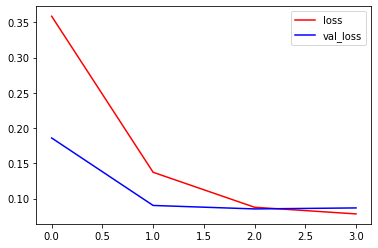

In [113]:
x_range=np.arange(len(history.history['loss']))
plt.plot(x_range,history.history['loss'],color='red',label='loss')
plt.plot(x_range,history.history['val_loss'],color='blue',label='val_loss')
plt.legend()
plt.show()

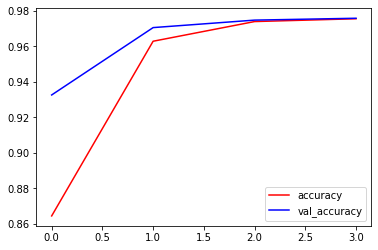

In [114]:
x_range=np.arange(len(history.history['loss']))
plt.plot(x_range,history.history['accuracy'],color='red',label='accuracy')
plt.plot(x_range,history.history['val_accuracy'],color='blue',label='val_accuracy')
plt.legend()
plt.show()

In [115]:
test=["i am busy","Our company has been released a new product which has impressive function to improve the older health. So if you need for more details, don't hesitate to ask for the question"]

In [116]:
test=np.array(test).reshape(len(test),)

In [117]:
test_real_sequences=tokenize.texts_to_sequences(test)
test_real_matrix=sequence.pad_sequences(test_real_sequences,maxlen=max_len)

In [118]:
prediction=model.predict(test_real_matrix)
print(prediction)

[[0.00080011]
 [0.01191409]]


- 0: not spam
- 1: spam

In [119]:

for index,messange in enumerate(test):
    if prediction[index]<0.5:
        result='Not spam'
    else:
        result='Spam'
    print("{}: {}   :{}".format(index+1,messange,result))

1: i am busy   :Not spam
2: Our company has been released a new product which has impressive function to improve the older health. So if you need for more details, don't hesitate to ask for the question   :Not spam
